In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import os
import shutil
import random
import numpy as np
from PIL import Image
import cv2

## Dividir train y test

In [89]:
categorias = ["Up", "Stop", "Down", "Prev"]
random.seed(42)  # Para reproducibilidad

# Crear carpetas de salida
for categoria in categorias:
    os.makedirs(os.path.join("../Dataset", "train", categoria), exist_ok=True)
    os.makedirs(os.path.join("../Dataset", "validate", categoria), exist_ok=True)

for categoria in categorias:
    carpeta_original = os.path.join("../Images", categoria)
    imagenes = [f for f in os.listdir(carpeta_original) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
    if not imagenes:
        print(f"⚠️ No hay imágenes en {carpeta_original}")
        continue

    # Mezclar y dividir datos
    random.shuffle(imagenes)
    split_idx = int(len(imagenes) * 0.8)
    train_files = imagenes[:split_idx]
    validate_files = imagenes[split_idx:]

    # Mover archivos a sus respectivas carpetas
    for file in train_files:
        shutil.copy(os.path.join(carpeta_original, file), os.path.join("../Dataset", "train", categoria, file))
        
    for file in validate_files:
        shutil.copy(os.path.join(carpeta_original, file), os.path.join("../Dataset", "validate", categoria, file))

    print(f"✅ {categoria}: {len(train_files)} train, {len(validate_files)} validate")

✅ Up: 292 train, 73 validate
✅ Stop: 276 train, 69 validate
✅ Down: 316 train, 80 validate
✅ Prev: 256 train, 64 validate


# Loading the dataset

In [174]:
def cargar_split(split):
    data = []
    split_folder = os.path.join("../Dataset", split)

    if not os.path.exists(split_folder):
        print(f"⚠️ No se encontró la carpeta: {split_folder}")
        return pd.DataFrame()

    for label in os.listdir(split_folder):
        label_folder = os.path.join(split_folder, label)
        if not os.path.isdir(label_folder):
            continue

        for file in os.listdir(label_folder):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(label_folder, file)

                # Cargar imagen y convertir a escala de grises
                img = Image.open(image_path).convert('L')
                img = img.resize((28, 28))  # Redimensionar a 28x28

                # Convertir la imagen a un array de 784 valores (1D)
                pixels = np.array(img).flatten()

                # Guardar el label como número y los píxeles
                data.append([label] + pixels.tolist())

    return pd.DataFrame(data, columns=["label"] + [f"pixel{i+1}" for i in range(28 * 28)])

# Cargar los datos de entrenamiento y validación
train_df = cargar_split("train")
test_df = cargar_split("validate")

In [172]:
train_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,254,252,247,232,211,190,173,161,144,137,...,179,179,178,176,109,86,87,83,60,56
1,252,245,235,218,202,184,169,161,142,137,...,179,179,179,175,106,85,86,84,60,56
2,156,156,156,154,149,146,141,124,112,116,...,177,168,78,60,48,49,56,54,54,72
3,130,133,130,124,103,106,117,149,151,150,...,174,171,165,161,182,95,36,39,42,37
4,96,109,108,94,98,133,165,182,165,148,...,173,167,159,180,113,34,37,39,39,34


# Data Visualization and Preprocessing

<Axes: xlabel='count', ylabel='label'>

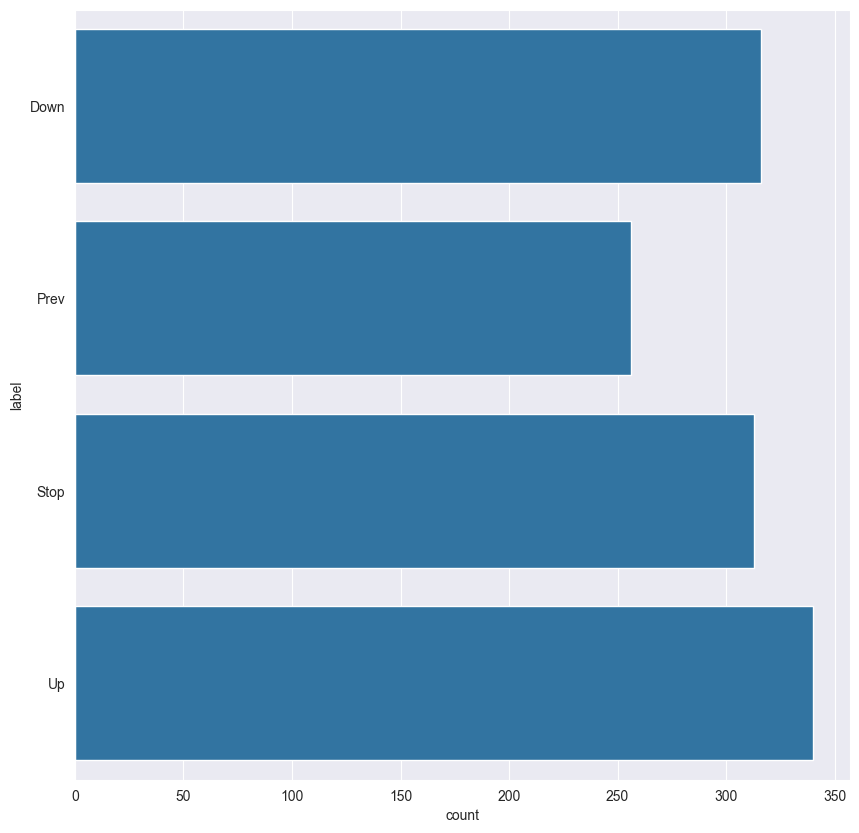

In [175]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

In [176]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [177]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [178]:
x_train = train_df.values
x_test = test_df.values

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [179]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [180]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

**Preview of first 10 images**

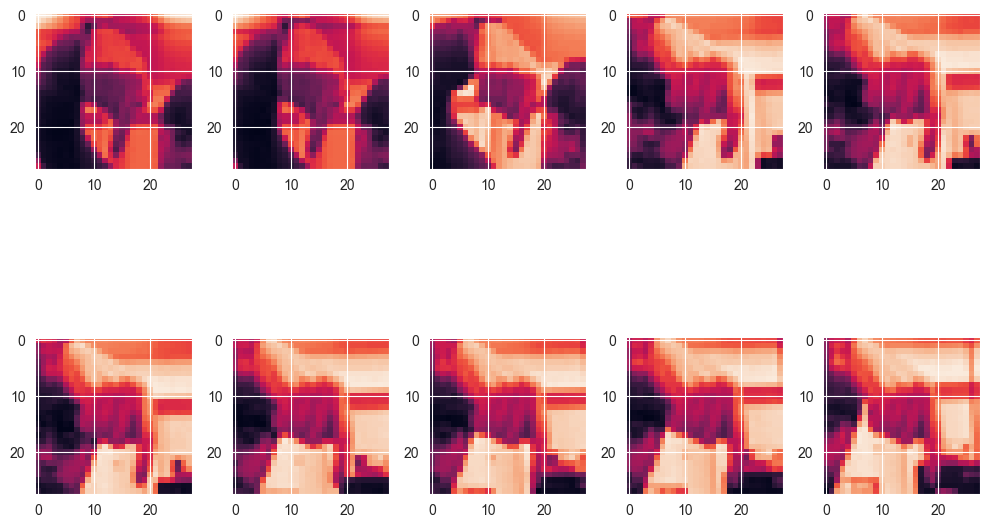

In [196]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k])
        k += 1
    plt.tight_layout()    

## Data Augmentation

In [182]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Training The Model

In [183]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [184]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(Conv2D(150 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.1))
model.add(Conv2D(250 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Conv2D(400 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 4 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

c:\Users\pablo\Desktop\DEV\SilAnt\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 28, 28, 150)    │       101,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 14, 14, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 14, 14, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 14, 14, 250)    │       337,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 14, 14, 400)    │       900,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 7, 7, 400)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 19600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │    10,035,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,378,064 (43.40 MB)

 Trainable params: 11,378,064 (43.40 MB)

 Non-trainable params: 0 (0.00 B)

In [189]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20


c:\Users\pablo\Desktop\DEV\SilAnt\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 851ms/step - accuracy: 0.3438 - loss: 1.4179 - val_accuracy: 0.4701 - val_loss: 1.1588 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 844ms/step - accuracy: 0.4829 - loss: 1.0463 - val_accuracy: 0.6929 - val_loss: 0.8874 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 818ms/step - accuracy: 0.6720 - loss: 0.7455 - val_accuracy: 0.8098 - val_loss: 0.5615 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 831ms/step - accuracy: 0.7241 - loss: 0.6075 - val_accuracy: 0.8804 - val_loss: 0.4422 - learning_rate: 0.0010
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 918ms/step - accuracy: 0.7416 - loss: 0.5457 - val_accuracy: 0.7989 - val_loss: 0.4538 - learning_rate: 0.0010
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.8170 - loss: 0.4432
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 842ms/step - accuracy: 0.8156 - loss: 0.4444 - val_accurac

In [190]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9875 - loss: 0.0361
Accuracy of the model is -  98.36956262588501 %


# Analysis after Model Training

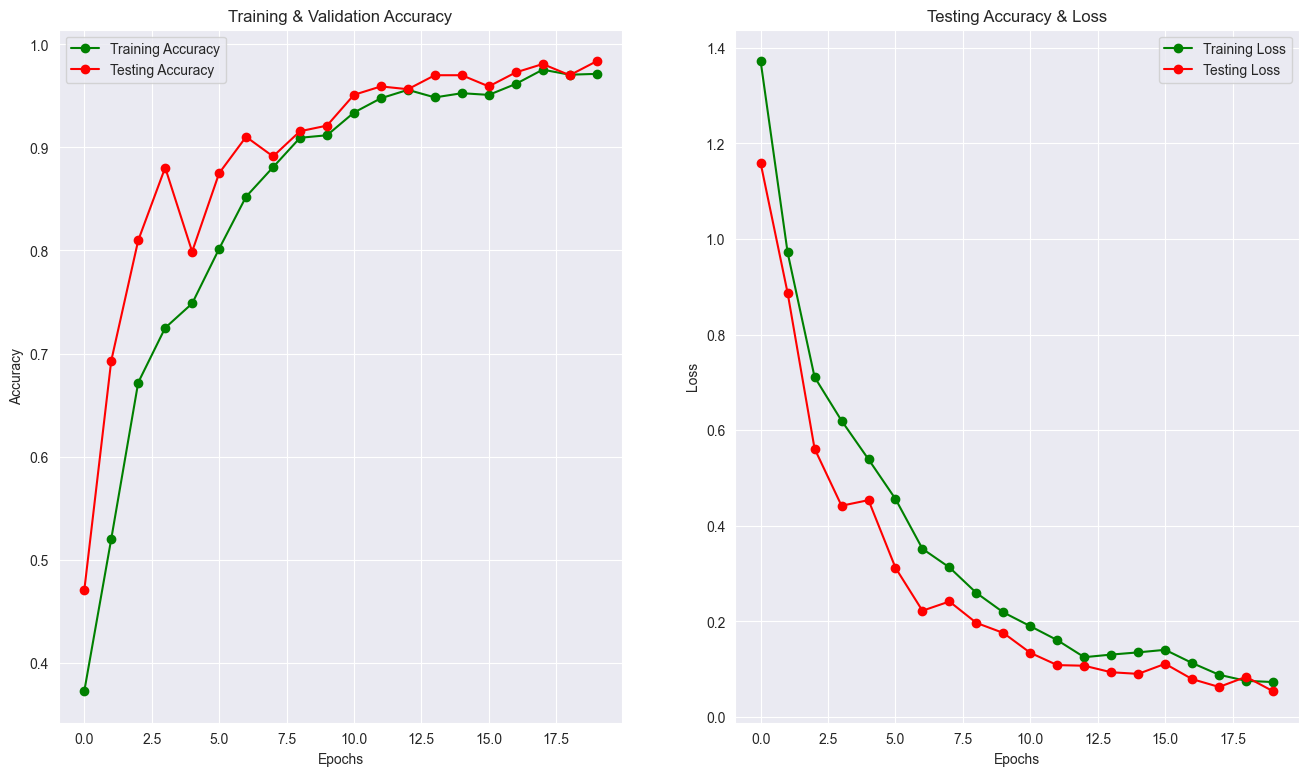

In [191]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

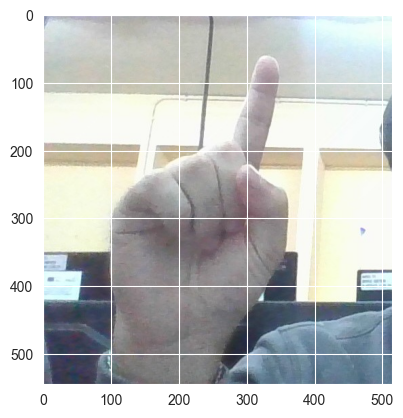

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicción: Stop


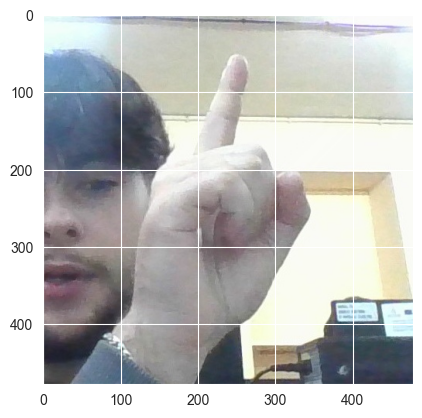

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicción: Up


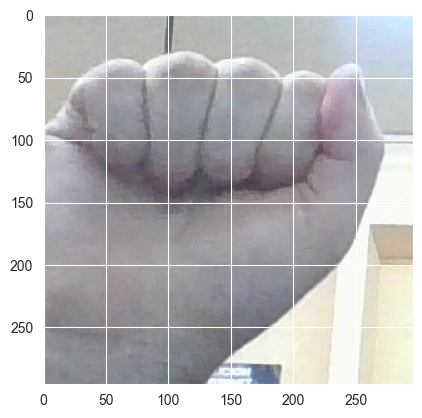

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicción: Stop


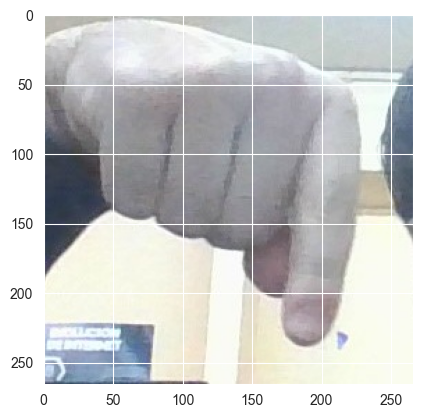

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicción: Down


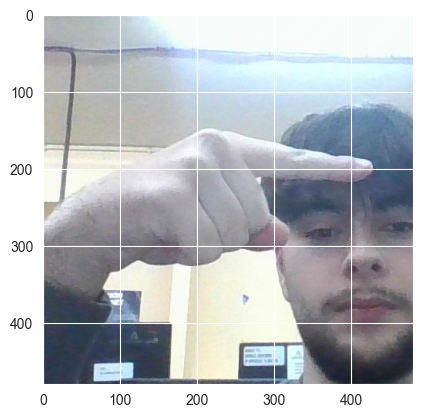

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicción: Down


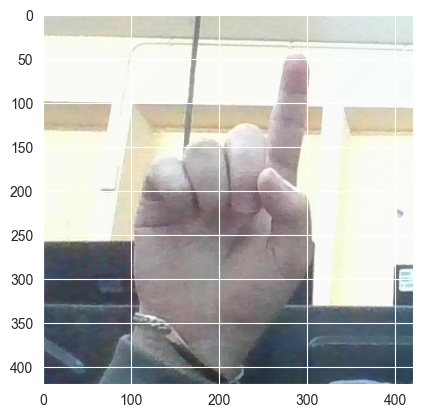

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicción: Stop


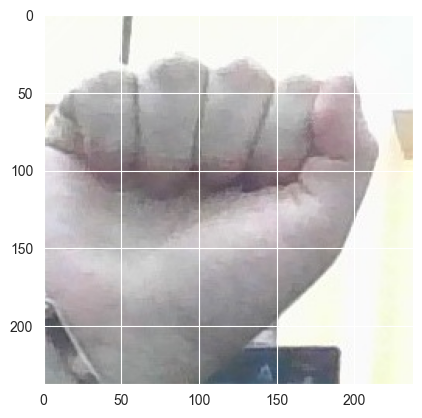

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicción: Stop


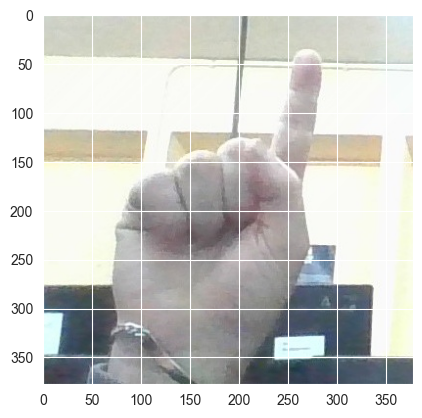

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicción: Stop


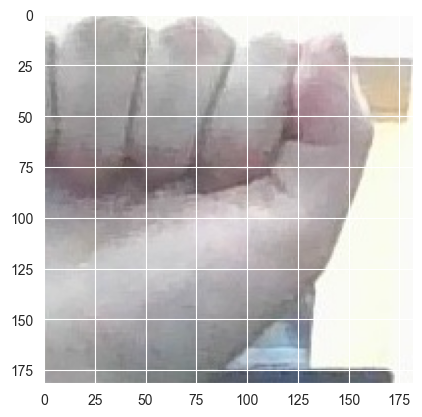

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicción: Stop


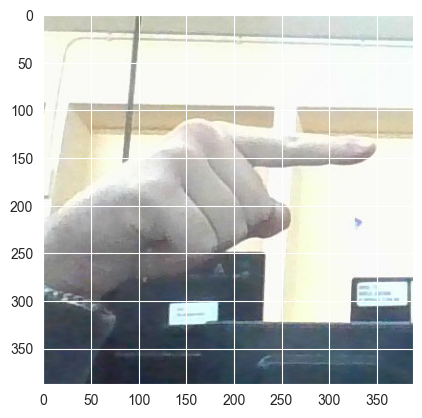

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicción: Stop


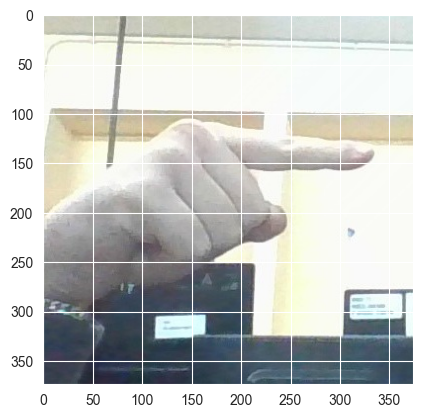

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicción: Stop
['Stop', 'Up', 'Stop', 'Down', 'Down', 'Stop', 'Stop', 'Stop', 'Stop', 'Stop', 'Stop']


In [195]:
# Lista para almacenar las imágenes
X = []
classnames = ['Down', 'Prev', 'Stop', 'Up']

# Iterar sobre todos los archivos en la carpeta
for file in os.listdir("../Images/Pruebas"):
    file_path = os.path.join("../Images/Pruebas", file)

    if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Verifica si el archivo es una imagen
        # Cargar la imagen en RGB (a color)
        img = Image.open(file_path)

        # Mostrar la imagen (opcional)
        plt.imshow(img)
        plt.show()

        img = img.convert('L')  # Convertir a escala de grises
        
        # Redimensionar la imagen a 28x28
        img = img.resize((28, 28))
        
        # Convertir la imagen a un array de numpy
        img = np.array(img)
        
        # Normalizar (dividir por 255) y cambiar la forma para que tenga 3 canales (RGB)
        img_normalized = img / 255.0
        img_reshaped = img_normalized.reshape(-1, 28, 28, 1)  # Cambiar el canal a 3 para RGB

        

        # Realizar la predicción
        prediction = classnames[np.argmax(model.predict(img_reshaped))]
        print(f"Predicción: {prediction}")
        
        # Añadir la imagen preprocesada a la lista
        X.append(prediction)

# Mostrar las predicciones
print(X)
